In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [3]:
# build dataset
block_size = 3
def build_dataset(words):
    X,Y = [],[]
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'------>',itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [4]:
def cmp(s,dt,t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt,t.grad)
    maxdiff = (dt-t.grad).abs().max().item()
    print(f'{s:15s}  | exact: {str(ex):5s}  |  approximate: {str(app):5s}  |  maxdiff:  {maxdiff}')

In [5]:
#MLP revisited
n_embd = 10 #the dimensioanlity of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,generator=g) * 0.1   # just for fun
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.1
b2 = torch.randn(vocab_size,generator=g) * 0.1
bngain = torch.randn((1,n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1,n_hidden)) * 0.1
# 如果用标准初始化,则偏置应该设置为0,但我们这里要手动实现反向传播,需要让问题变得更复杂来检查我们结果的正确性.让偏置为0会使问题简单,进而掩盖我们的错误
parameters = [C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [6]:
batch_size = 32
n = batch_size
ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
Xb,Yb = Xtr[ix],Ytr[ix]

In [7]:
emb = C[Xb]
embcat = emb.view(emb.shape[0],-1)
#Linear Layer 1
hprebn = embcat @ W1 + b1
#BatchNorm layer
bnmeani = 1/n * hprebn.sum(0,keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0,keepdim=True)  #note: Bessel's correction (dividing by n-1,not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-Linearity
h = torch.tanh(hpreact)
#Linear layer 2
logits = h @ W2 + b2
#cross entropy loss
logit_maxes = logits.max(1,keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3327, grad_fn=<NegBackward0>)

In [9]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n
dprobs = (1.0/ probs) * dlogprobs
# dprobs = counts * dcounts_sum_inv + dcounts * counts_sum_inv
# dcounts_sum = -(counts_sum)**-2 * dcounts_sum_inv
# dcounts = torch.ones_like(counts) * dcounts_sum
# dprobs = (counts + torch.ones_like(counts) * (-(counts_sum)**-2) * counts_sum_inv) * dcounts_sum_inv
# dcounts_sum_inv = dprobs / (counts + (torch.ones_like(counts) * (-(counts_sum)**-2) * counts_sum_inv))
# dcounts_sum_inv = dcounts_sum_inv[range(n),Yb].view(-1,1)
# dcounts_sum_inv

#反思:不能用全微分公式!!! 因果搞反了!! d(xxx) 知识简写,实际上是loss对xxx的导数!!!

dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True)
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum

dnorm_logits = norm_logits.exp() * dcounts
dlogits = dnorm_logits.clone()     #不要用1.0*   用clone()
dlogit_maxes = -(1.0 * dnorm_logits).sum(1,keepdim=True)
addlogits = torch.zeros_like(logits)
addlogits[range(n),logits.argmax(1)] = 1
dlogits += addlogits * dlogit_maxes

db2 = dlogits.sum(0)
dh = dlogits @ W2.t()
dW2 = h.t() @ dlogits 

dhpreact = (1-h**2)*dh
#bias发生广播之后是行向量 按行复制 !
dbnbias = dhpreact.sum(0,keepdim=True)   #时刻注意形状匹配!  为什么会出现这种情况?因为矩阵按元素相乘实际上发生了广播机制,而这是隐藏在pytorch里的!
dbnraw = bngain * dhpreact
dbngain  = (bnraw * dhpreact).sum(0,keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(dim=0,keepdim=True)
dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv

dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += 2 * bndiff * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0,keepdim=True)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.t()
dW1 = embcat.t() @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs         | exact: True   |  approximate: True   |  maxdiff:  0.0
probs            | exact: True   |  approximate: True   |  maxdiff:  0.0
counts_sum_inv   | exact: True   |  approximate: True   |  maxdiff:  0.0
counts_sum       | exact: True   |  approximate: True   |  maxdiff:  0.0
counts           | exact: True   |  approximate: True   |  maxdiff:  0.0
norm_logits      | exact: True   |  approximate: True   |  maxdiff:  0.0
logit_maxes      | exact: True   |  approximate: True   |  maxdiff:  0.0
logits           | exact: True   |  approximate: True   |  maxdiff:  0.0
h                | exact: True   |  approximate: True   |  maxdiff:  0.0
W2               | exact: True   |  approximate: True   |  maxdiff:  0.0
b2               | exact: True   |  approximate: True   |  maxdiff:  0.0
hpreact          | exact: True   |  approximate: True   |  maxdiff:  0.0
bngain           | exact: True   |  approximate: True   |  maxdiff:  0.0
bnbias           | exact: True   |  approximate: Tr

In [17]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3327369689941406 diff: 0.0


In [10]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits           | exact: False  |  approximate: True   |  maxdiff:  5.3551048040390015e-09


In [13]:
F.softmax(logits,1)[0]

tensor([0.0661, 0.0858, 0.0190, 0.0505, 0.0182, 0.0839, 0.0217, 0.0360, 0.0200,
        0.0301, 0.0387, 0.0340, 0.0400, 0.0291, 0.0340, 0.0133, 0.0084, 0.0186,
        0.0166, 0.0619, 0.0495, 0.0223, 0.0265, 0.0707, 0.0565, 0.0273, 0.0212],
       grad_fn=<SelectBackward0>)

In [14]:
dlogits[0] * n

tensor([ 0.0661,  0.0858,  0.0190,  0.0505,  0.0182,  0.0839,  0.0217,  0.0360,
        -0.9800,  0.0301,  0.0387,  0.0340,  0.0400,  0.0291,  0.0340,  0.0133,
         0.0084,  0.0186,  0.0166,  0.0619,  0.0495,  0.0223,  0.0265,  0.0707,
         0.0565,  0.0273,  0.0212], grad_fn=<MulBackward0>)

In [ ]:
dlogits[0].sum()        #和近似为0

tensor(-2.3283e-09, grad_fn=<SumBackward0>)

我们可以认为存在一种用于平衡的力，像一套滑轮，对于正确预测概率和错误预测概率施加相反方向的力，对于正确预测的概率会提高，而错误概率会降低。比如说如果正确预测概率为1，其他都为0，则这一行的导数都会为0，因为已经正确预测了，不需要改变，对loss没有任何影响。但如果有一个错误的概率，那么就会对正确的概率施加相同大小的提升。

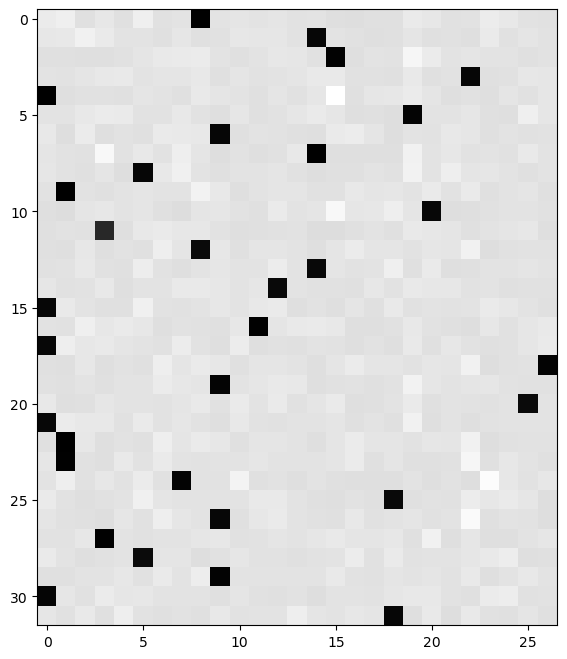

In [16]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(),cmap='gray')
plt.show()

In [18]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(7.1526e-07, grad_fn=<MaxBackward1>)


In [40]:
dhprebn = bngain * bnvar_inv/n * (n * dhpreact - dhpreact.sum(0,keepdim=True)-n/(n-1)* bnraw * (dhpreact*bnraw).sum(0,keepdim=True))
cmp('hprebn',dhprebn,hprebn)

hprebn           | exact: False  |  approximate: True   |  maxdiff:  4.656612873077393e-10


In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))